# Mean Shift algorithm

In this nootebook we describe and implement mean shift algorithm. Mean shift is an unsupervised algorithm which tries to find modes of data, then it will consider points with a same mode as a cluster.

Firstly, for each point Mean shift creates a window. In other words, it regards a constance distance for each point, then it will compare other points with a candidate point to find those points that are at most at that distance. This distance is knowns as a window.

For creating a window we will use p-norm. There are various distances such as `Euclidian`, `Manhatan`, etc.

<center><h5>this figure shows various norms</h5></center>

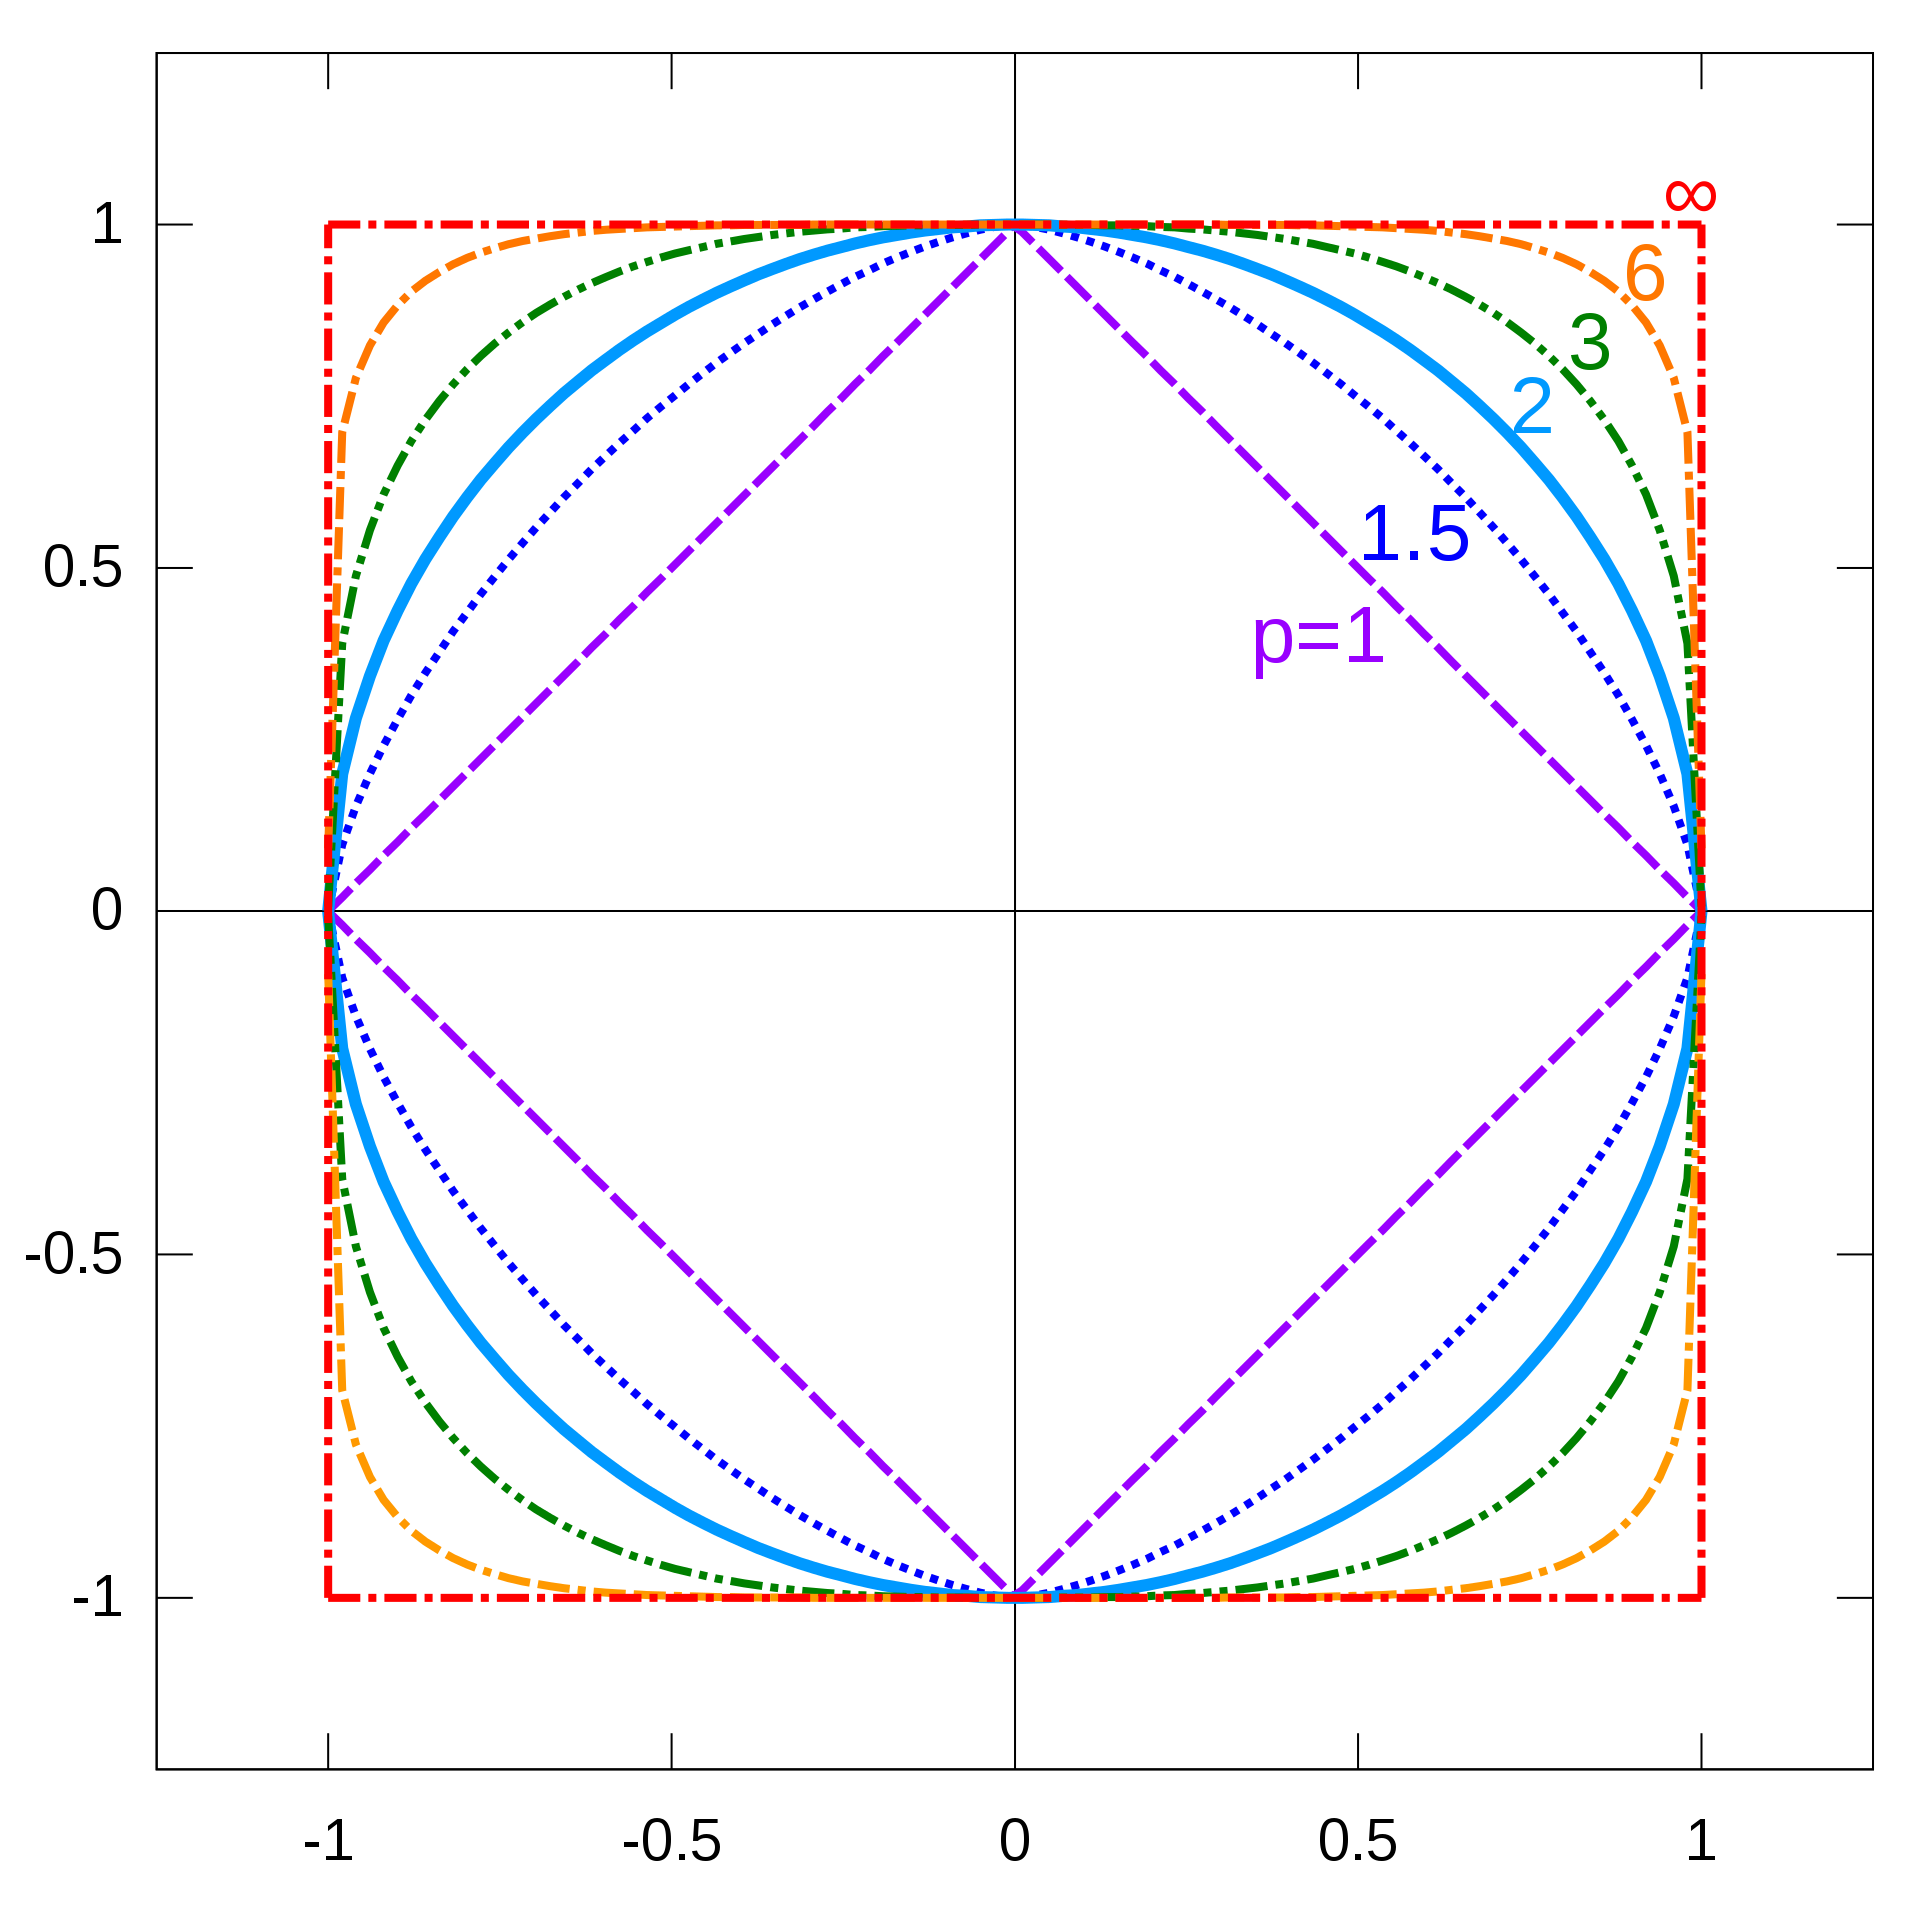

- Following formula evaluate norms, and we will use this to create a window:

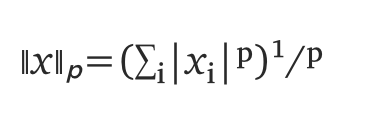


where `x` is our point, and `p` identifies type of a norm.

Secondly, we must evaluate center of mass, expected value, or weighted average of data because this algorithm works by finding center of mass, and it continues assessing that until find a mode, then mean shift will consider starting point and this mode as a cluster, and it also will assign other points to this cluster if they have same mode.

Thirdly, for finding an expected value we need to know data distribution, so we will employ `Kernel Distribution Estimation` to estimate data distribution. Next, we will evaluate weighted sum of points that are in a same window, then if weighted sum is not equal to that point which is center of window, we will change center of window to new point which is center of mass of points that are in window. For finding center of mass by using KDE we will employ this formula


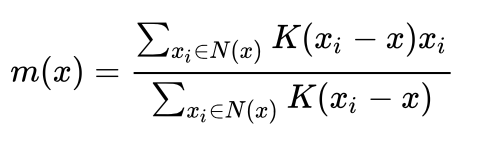

where K(x<sub>i</sub>-x) is kernel function, and N(x) is the neighborhood of x. For moving center of window to new center we use `Mean Shift Vector` which is `m(x) - x`.


Finally, we contunue these steps until convergence which center of window and weighted sum will be equal.

In [2]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from IPython.display import HTML
import matplotlib.patches as patches

In [3]:
%matplotlib inline
plt.rcParams["animation.html"] = "jshtml"
plt.rcParams['figure.dpi'] = 150  
plt.ioff()

**This function will visualzie data**

In [4]:
def display_cluster_cir(X,km=[], num_clusters=0):
    color = 'brgcmyk'
    alpha = 0.5
    s = 20
    if num_clusters == 0:
        plt.scatter(X['theta'],X['r'],c = color[0],alpha = alpha,s = s)
    else:
        for i in range(num_clusters):
            plt.scatter(X['theta'][km.labels_==i],X['r'][km.labels_==i],c = color[i],alpha = alpha,s=s)
            plt.scatter(km.cluster_centers_[i][0],km.cluster_centers_[i][1],c = color[i], marker = 'x', s = 100)

**In this section we will impelement `Mean Shift`**

this class comprises nine methods:
- `identify_norm()` identify norm type, and it returns norm number. 
- `norm_p(centroid, w, data, norm=2, isNorm=False)` will create a window, or will assess distance between two points.
- `fit()` runs algorithm and keeps clusters
- `show()` shows clusters
- `_gausian_kernel(points, centeroid)` estimates samples distribution by using `Gaussian Kernel`
- `_itr()` runs a loop for each point until it converges on center of mass
- `trace()`, `init_plot()`, and `trace_data` create a animation that shows process of convergence

In [40]:
class Mean_Shift(object):
    def __init__(self, bandwidth, data, dist='l2', kernel='G'):
        self.dist = dist
        self.bandwidth = bandwidth
        self.data = data
        self.kernel = kernel
        self.clusters = {}
        
        self.fig, self.ax = None, None
        self.circle_plot = None
        self.visualaize_x_hat = []
        self.visualaize_encircling_points = []
        self.visualaize_point = []
    
    def identify_norm(self):
        return int(self.dist.split('l')[1])
    
    def norm_p(self, centroid, w, data, norm=2, isNorm=False):                  
        distance = data.copy()
        encircling_points = 0

        for dim in range(data[0].shape[0], 0, -1):
            dim -= 1
            distance[:, dim] = np.power(data[:, dim]-centroid[dim], norm)
        
        distance = distance.sum(axis=1)
        distance = np.power(distance, 1/norm)
            
        if not isNorm:            
            if data[0].shape[0] == 3:
                distance_t = np.array([distance[0], distance[0], distance[0]])               
                encircling_points = data[0][distance_t <= w]
                encircling_points = np.array([np.reshape(encircling_points, (3, data[0].shape[1]))])
            else:
                encircling_points = data[distance <= w]
        
        return encircling_points, centroid, distance    
    

    def fit(self):

        for point in self.data:
            _, cluster_center = self._itr(point)
            if cluster_center.shape[0] == 3:
                cluster_center = f"{(cluster_center[0], cluster_center[1], cluster_center[2])}"
            else:
                cluster_center = f"{(cluster_center[0], cluster_center[1])}"

            if cluster_center in self.clusters:
                self.clusters[cluster_center].append(point)
            else:
                self.clusters[cluster_center] = [point]

    def show(self):
        self.fig, self.ax = plt.subplots()
        self.ax.cla()
        color = 'brgcmyk'
        numbers = [0, 1, 2, 3, 4, 5]
        choice = 0
        print(f"number of clusters: {len(self.clusters.keys())}")
        for key in self.clusters.keys():

            p = np.array(self.clusters[key])
            self.ax.plot(p[:, 0], p[:, 1], 'o', color=color[choice])
            
            if choice != 5:
                choice +=1

    def show_img(self):
        self.fig, self.ax = plt.subplots()
        self.ax.cla()
        color = 'brgcmyk'
        numbers = [0, 1, 2, 3, 4, 5]
        choice = 0
        print(f"number of clusters: {len(self.clusters.keys())}")
        for key in self.clusters.keys():

            p = np.array(self.clusters[key])
            self.ax.plot(p[:, 0], p[:, 1], p[:, 2], 'o', color=color[choice])
            
            if choice != 5:
                choice +=1            
        
    def _gaussian_kernel(self, points, centeroid):
        if centeroid.shape[0] == 3:
            cent_X = centeroid[0]
            cent_Y = centeroid[1]
            cent_Z = centeroid[2]
            _, _, norm2 = self.norm_p(centroid=np.array((cent_X, cent_Y, cent_Z)), data=points, w=self.bandwidth, norm=2, isNorm=True)
            norm2 /= self.bandwidth
            norm2 = np.exp(-2 * np.power(norm2, 2))        
            result = np.multiply(np.power(2 * np.pi, -self.bandwidth/2), norm2)

        else:
            cent_X = centeroid[0]
            cent_Y = centeroid[1]
            _, _, norm2 = self.norm_p(centroid=np.array((cent_X, cent_Y)), data=points, w=self.bandwidth, norm=2, isNorm=True)
            norm2 /= self.bandwidth
            norm2 = np.exp(-2 * np.power(norm2, 2))        
            result = np.multiply(np.power(2 * np.pi, -self.bandwidth/2), norm2)
        return result
    
    def _itr(self, point):

        if point.shape[0] == 3:
            x_hat = np.array((point[0], point[1], point[2]))
        else:
            x_hat = np.array((point[0], point[1]))
        
        while True:
            encircling_points, center, _ = self.norm_p(centroid=x_hat, w=self.bandwidth, data=self.data, norm=self.identify_norm())

            self.visualaize_x_hat.append(x_hat)
            self.visualaize_encircling_points.append(encircling_points)
            self.visualaize_point.append(point)                

            if self.kernel == 'G':

                fx = self._gaussian_kernel(points=encircling_points, centeroid=x_hat)
                if point.shape[0]==3:
                    fx = np.array([fx[:, 0], fx[:, 1], fx[:, 2]])
                    print(fx.shape)                    
                else:
                    fx_d = np.reshape(fx, (fx.shape[0], 1))                                     
                    fx = np.insert(fx_d, 1, fx,axis=1)                    

                subtract = encircling_points - center
                numerator = np.multiply(subtract, fx).sum(axis=0)
                denumerator = fx.sum()
                updated_mean = numerator / denumerator
                x_hat = updated_mean + x_hat

            
            if (x_hat==np.array([center])).all():
                # print(f"Convergence: point: {point}, center: {center}")
                return point, center
    
    def trace(self): 
        self.ax.cla()
        self.anim = animation.FuncAnimation(self.fig, self.trace_data, frames=len(self.visualaize_point), interval=20, blit=True, init_func=self.init_plot)
        HTML(self.anim.to_html5_video())
        rc('animation', html='html5')
        return self.anim
            
    def init_plot(self):        
        redius=self.bandwidth 
        center=self.visualaize_x_hat[0]
        inner_points=self.visualaize_encircling_points[0]
        all_data=self.data
        isDataVisualization=False
        title='Fig'
        
        self.ax.set_title(title)
        self.lr, = self.ax.plot([], [], 'o', color='r', lw=2)
        self.ax.plot(all_data[:, 0], all_data[:, 1], 'o', color='y')
        
        self.lr.set_data(center[0], center[1])
        
        
        return (self.lr, )
        

    def trace_data(self, frame_number):
        center = self.visualaize_x_hat[frame_number]
        inner_points = self.visualaize_encircling_points[frame_number]
        all_data = self.data  
        title=f"point: {self.visualaize_point[frame_number]}"
        
        if self.circle_plot == None:
            self.circle_plot = plt.Circle((center[0], center[1]), self.bandwidth, color='b', fill=False)
            self.ax.add_patch(self.circle_plot)
        else:
            self.circle_plot.center = center[0], center[1]
        self.ax.set_title(title)
        # center
        self.lr.set_data(center[0], center[1])
        return (self.lr,)

              

In [44]:
data = pd.read_csv('data_csv/data1.csv')
data2 = pd.read_csv('data_csv/data2.csv')
data3 = pd.read_csv('data_csv/data3.csv')
data4 = pd.read_csv('data_csv/data4.csv')
data5 = pd.read_csv('data_csv/data5.csv')
data6 = pd.read_csv('data_csv/data6.csv')
data7 = pd.read_csv('data_csv/data7.csv')

**run algorthim with sample data 1**

number of clusters: 6


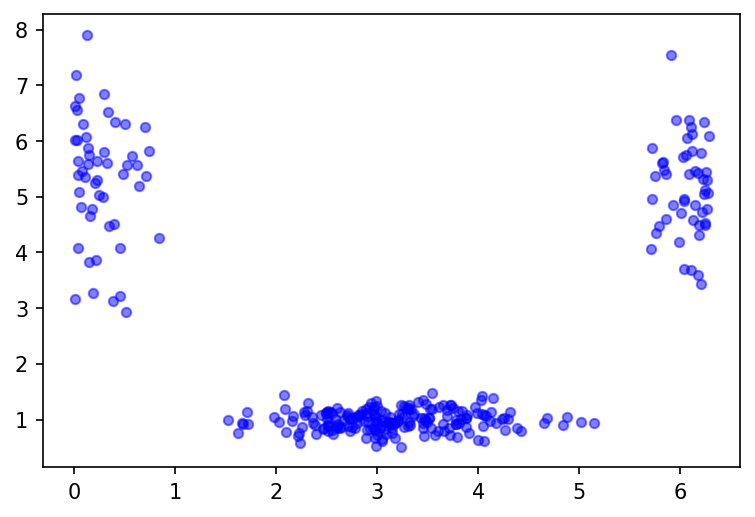

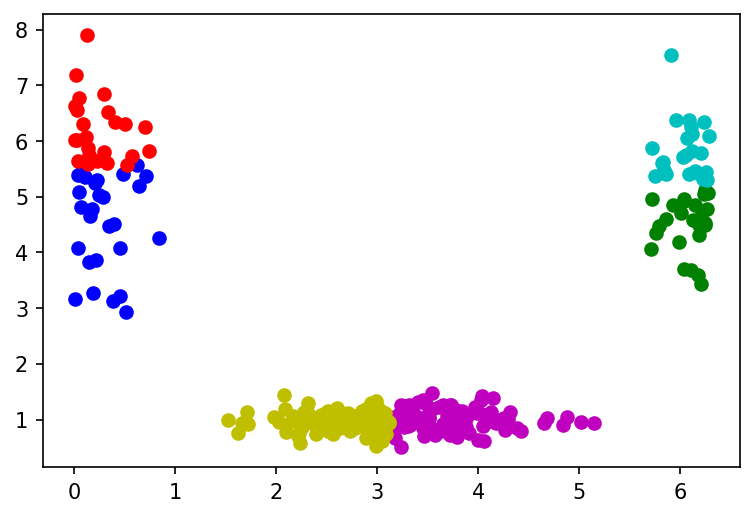

In [51]:
display_cluster_cir(data)
ms1 = Mean_Shift(bandwidth=2, data=data.to_numpy(), dist="l2")
ms1.fit()
ms1.show()

**run algorthim with sample data 2**

number of clusters: 4


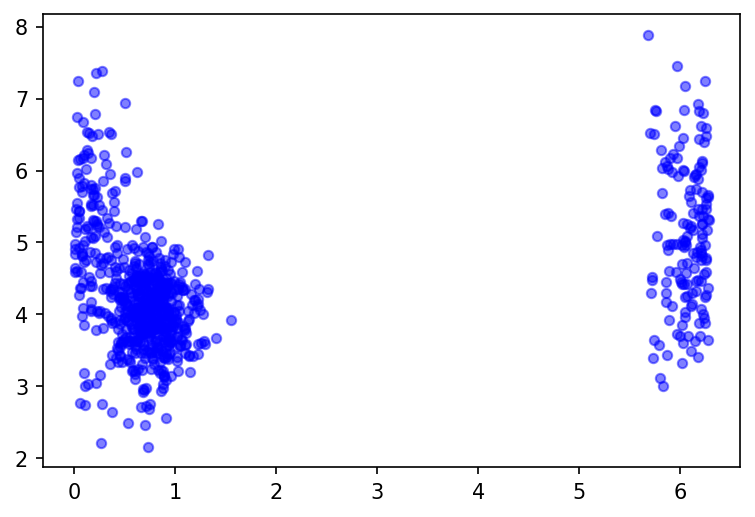

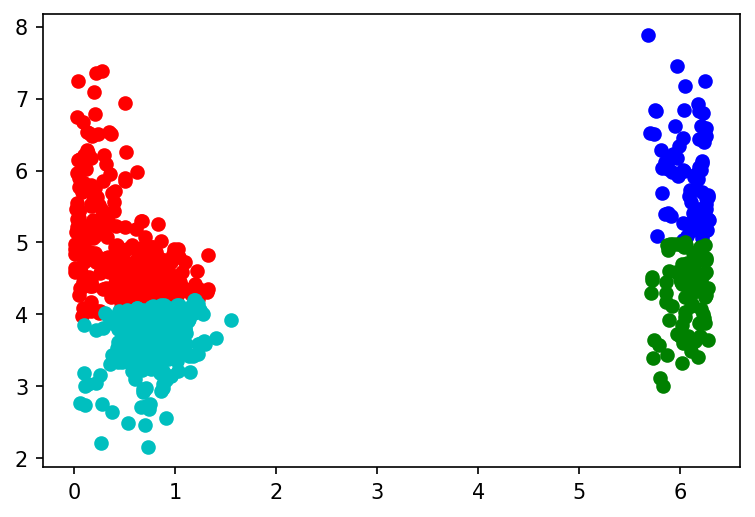

In [47]:
display_cluster_cir(data2)
ms2 = Mean_Shift(bandwidth=2, data=data2.to_numpy())
ms2.fit()
ms2.show()

**run algorthim with sample data 3**

number of clusters: 9


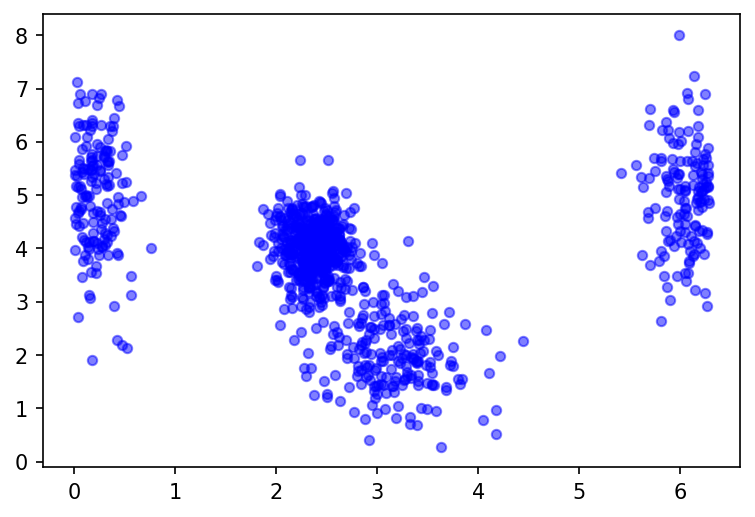

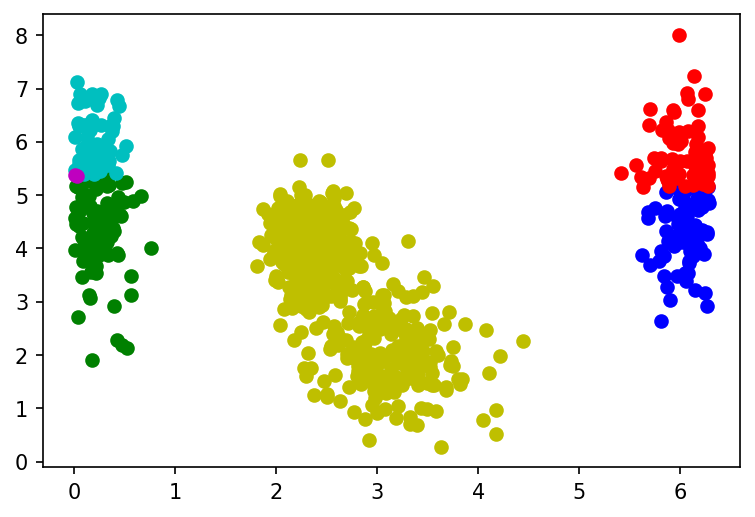

In [38]:
display_cluster_cir(data3)
ms3 = Mean_Shift(bandwidth=1, data=data3.to_numpy())
ms3.fit()
ms3.show()

**run algorthim with sample data 4**

number of clusters: 10


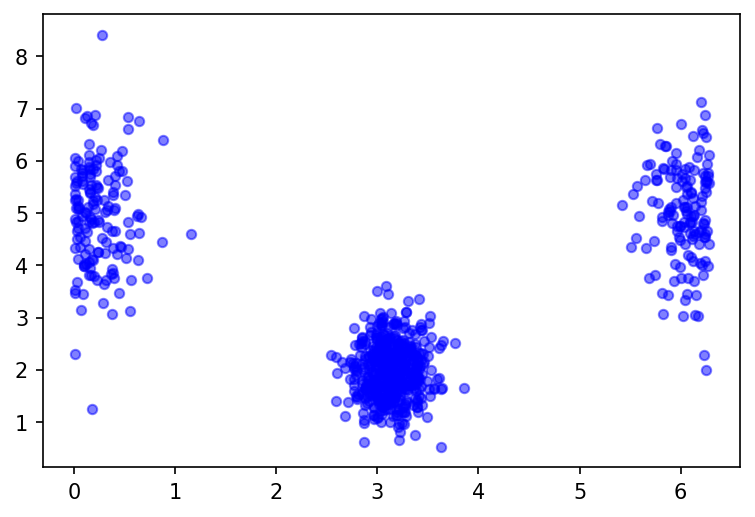

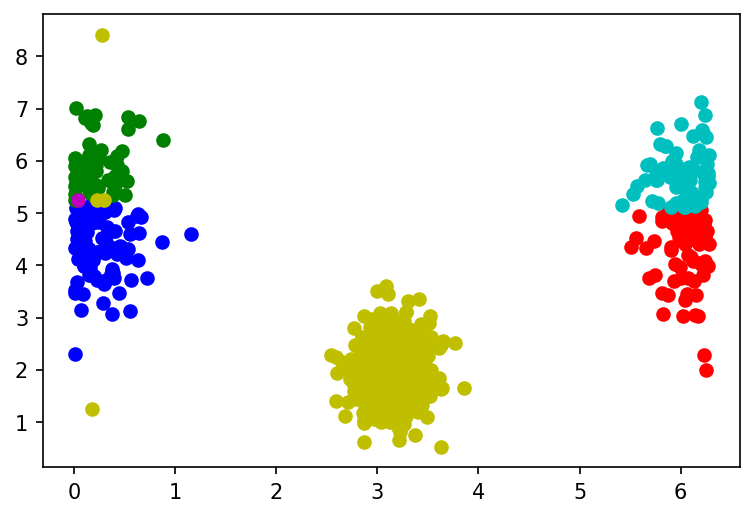

In [37]:
display_cluster_cir(data4)
ms4 = Mean_Shift(bandwidth=1, data=data4.to_numpy())
ms4.fit()
ms4.show()

**run algorthim with sample data 5**

number of clusters: 4


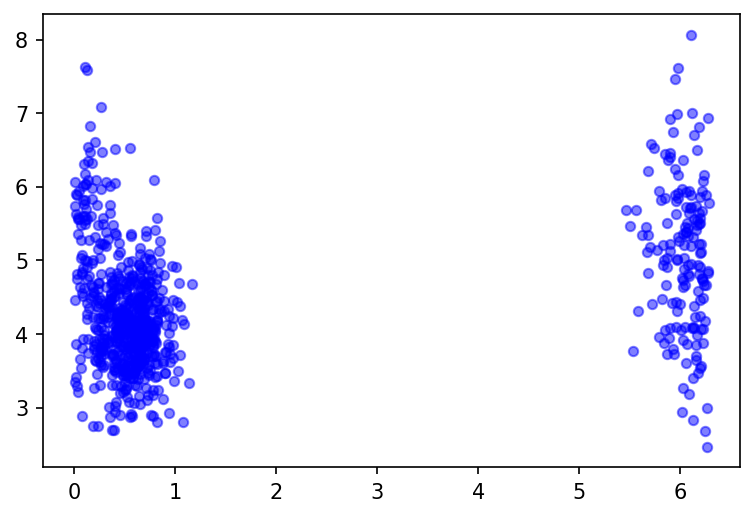

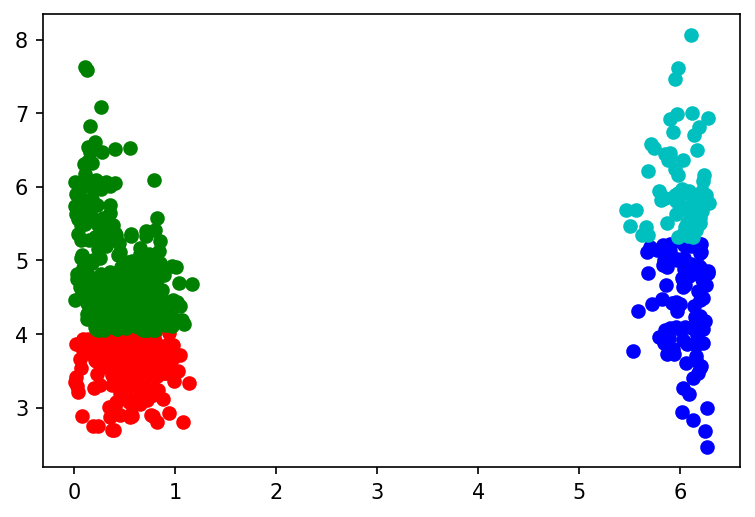

In [35]:
display_cluster_cir(data5)
ms5 = Mean_Shift(bandwidth=1, data=data5.to_numpy())
ms5.fit()
ms5.show()

**run algorthim with sample data 6**

number of clusters: 6


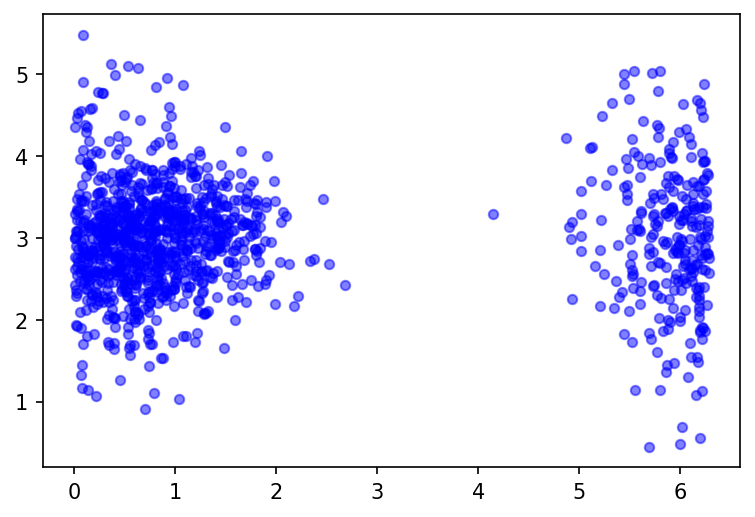

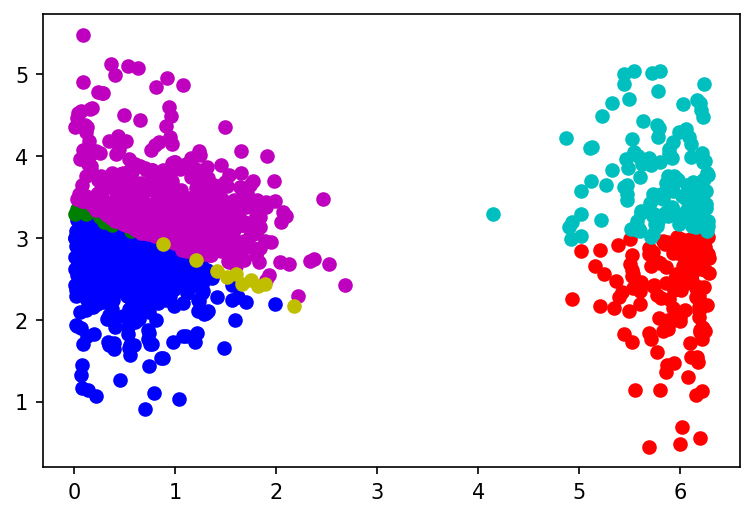

In [34]:
display_cluster_cir(data6)
ms6 = Mean_Shift(bandwidth=2, data=data6.to_numpy())
ms6.fit()
ms6.show()

**run algorthim with sample data 7**

number of clusters: 8


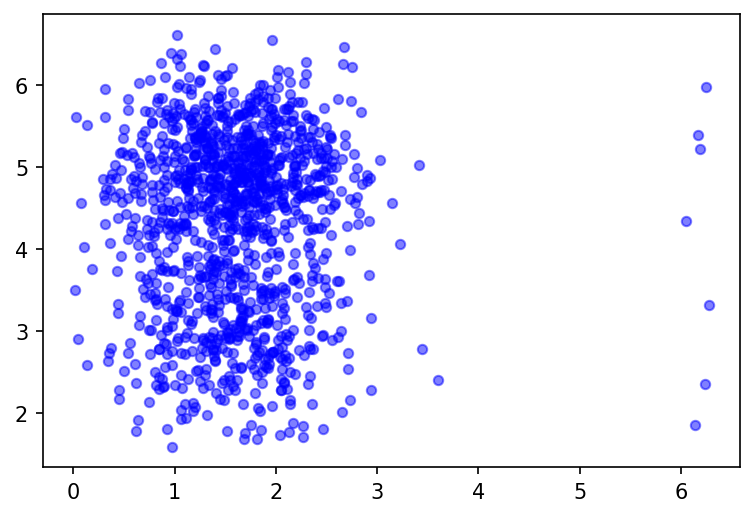

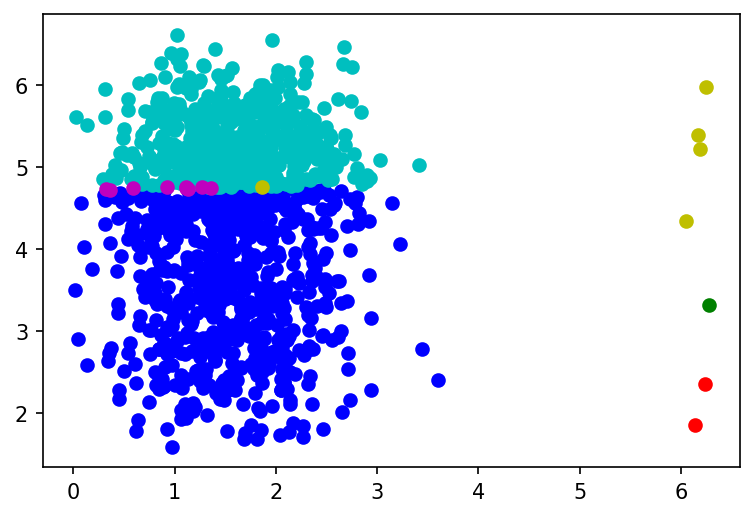

In [26]:
display_cluster_cir(data7)
ms7 = Mean_Shift(bandwidth=2, data=data7.to_numpy())
ms7.fit()
ms7.show()

number of clusters: 2


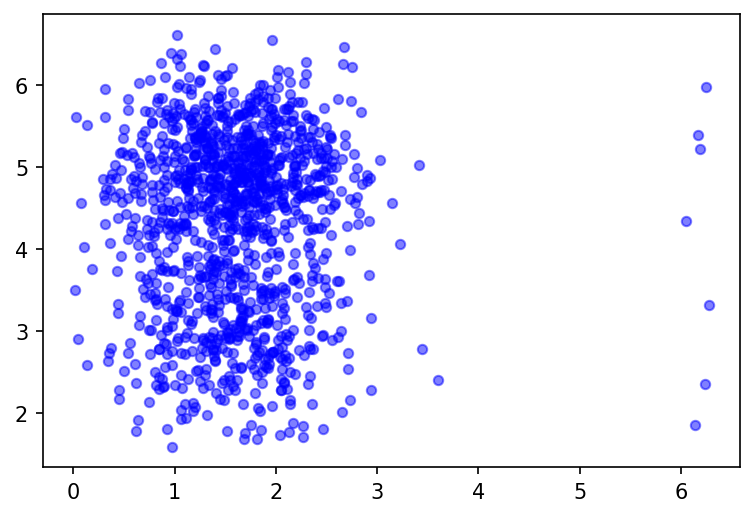

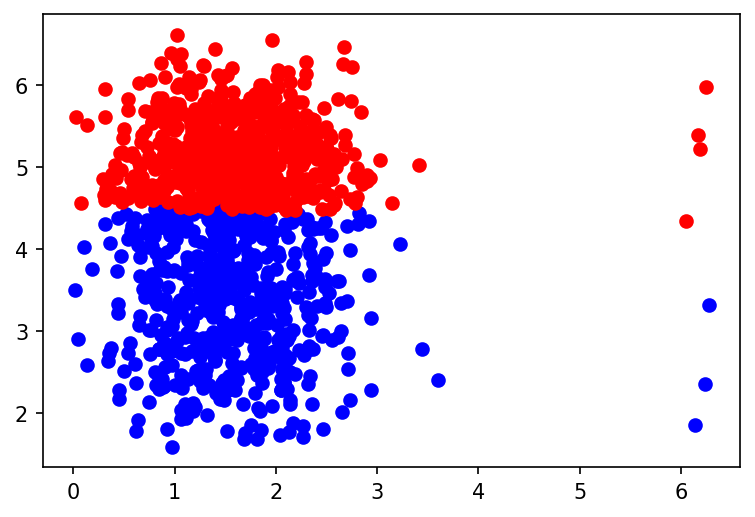

In [23]:
display_cluster_cir(data7)
ms7 = Mean_Shift(bandwidth=3, data=data7.to_numpy())
ms7.fit()
ms7.show()

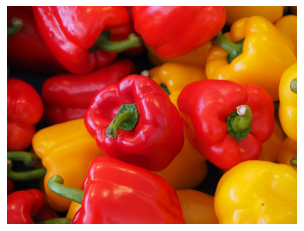

In [3]:
img = plt.imread('data/peppers.jpg')
plt.imshow(img)
plt.axis('off');

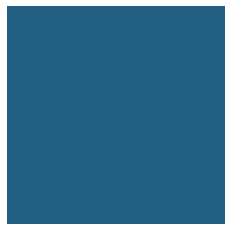

In [4]:
R = 35
G = 95
B = 131
plt.imshow([[np.array([R,G,B]).astype('uint8')]])
plt.axis('off');

In [5]:
img_flat = img.reshape(img.shape[0]*img.shape[1],3)

In [ ]:
data8 = np.array([[img_flat[:,0], img_flat[:,1], img_flat[:, 2]]])
ms8 = Mean_Shift(bandwidth=1, data=data8)
ms8.fit()
ms8.show_img()